In [1]:
import os
import wandb

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
# from stable_baselines3.common.env_checker import check_env

import heapq
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import matplotlib.animation as animation
from IPython.display import display, clear_output

In [3]:
class DGSN_Env(gym.Env):
    def __init__(self, grid_size=10, max_static_obstacles=30, max_dynamic_obstacles=20, max_steps=1000):
        super(DGSN_Env, self).__init__()
        self.grid_size = grid_size
        self.max_static_obstacles = max_static_obstacles
        self.max_dynamic_obstacles = max_dynamic_obstacles
        # self.num_static_obstacles = np.random.randint(1,10)
        # self.num_dynamic_obstacles = np.random.randint(1,21)
        # self.agent_pos = np.array(np.random.uniform(0, self.grid_size, size=2).round(1))
        # self.goal_pos = np.array(np.random.uniform(0, self.grid_size, size=2).round(1))
        self.num_static_obstacles = 30
        self.num_dynamic_obstacles = 20

        self.agent_pos = np.array(np.random.randint(0, self.grid_size, size=2))
        self.goal_pos = np.array(np.random.randint(0, self.grid_size, size=2))
        
        self.dynamic_obstacles = self._init_dynamic_obstacles()
        self.static_obstacles = self._init_static_obstacles()
        
        self.close_call, self.discomfort, self.current_step, self.ep_no = 0, 0, 1, 0
        self.dist_factor = 2
        self.max_steps = max_steps
        self.total_reward = 0
        
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Dict({
            'agent': spaces.Box(low=0, high=grid_size, shape=(2,), dtype=np.float32),
            'dyn_obs': spaces.Box(low=0, high=grid_size, shape=(self.max_dynamic_obstacles, 2), dtype=np.float32),
            'sta_obs': spaces.Box(low=0, high=grid_size, shape=(self.max_static_obstacles, 2), dtype=np.float32)
        })
        
        wandb.login()
        wandb.init(project='DGSN_runs')
        
        self.safe = True
        
        # Evaluation Metrics
        self.Avg_Success_Rate = 0
        self.Avg_Collision_Rate, self.ep_collision_rate, self.collision_count = 0, 0, 0
        self.Avg_Min_Time_To_Collision, self.min_time_to_collision = 0, 0
        self.Avg_Wall_Collision_Rate, self.wall_collision_count = 0, 0
        self.Avg_Obstacle_Collision_Rate, self.obstacle_collision_count = 0, 0
        self.Avg_Human_Collision_Rate, self.human_collision_count = 0, 0

        self.Avg_Timeout = 0
        self.Avg_Path_Length = 0
        self.Avg_Stalled_Time, self.stalled_time = 0, 0

        self.Avg_Discomfort, self.ep_discomfort = 0, 0
        self.Avg_Human_Distance, self.ep_human_distance, self.human_distance = 0, 0, 0
        self.Avg_Closest_Human_Distance, self.closest_human_distance = 0, 0
        self.Min_Closest_Human_Distance = 0
        self.goal_reached = 0
        self.timeout = 0

    # def _init_static_obstacles(self):
    #     obstacles = []
    #     for _ in range(self.num_static_obstacles):
    #         obstacles.append(np.random.uniform(0, self.grid_size, size=2).round(1))
    #     return obstacles
    
    # def _init_dynamic_obstacles(self):
    #     obstacles = []
    #     for _ in range(self.num_dynamic_obstacles):
    #         start_pos = np.random.uniform(0, self.grid_size, size=2).round(1)
    #         end_pos = np.random.uniform(0, self.grid_size, size=2).round(1)
    #         path = self._compute_path(start_pos, end_pos)
    #         obstacles.append({
    #             'start': start_pos,
    #             'end': end_pos,
    #             'current': start_pos.copy(),
    #             'angle': np.rad2deg(np.arctan2(end_pos[1] - start_pos[1], end_pos[0] - start_pos[0])),
    #             'distance': np.linalg.norm(end_pos - start_pos),
    #             'path': path if path else []
    #         })
    #     return obstacles

    def _init_static_obstacles(self):
        obstacles = []
        for _ in range(self.num_static_obstacles):
            # obstacles.append(np.random.uniform(0, self.grid_size, size=2).round(1))
            obstacles.append(np.array(np.random.randint(1, self.grid_size, size=2)))
        return obstacles
    
    def _init_dynamic_obstacles(self):
        obstacles = []
        for _ in range(self.num_dynamic_obstacles):
            # start_pos = np.random.uniform(0, self.grid_size, size=2).round(1)
            # end_pos = np.random.uniform(0, self.grid_size, size=2).round(1)
            start_pos = np.array(np.random.randint(0, self.grid_size, size=2))
            end_pos = np.array(np.random.randint(0, self.grid_size, size=2))
            path = self._compute_path(start_pos, end_pos)
            obstacles.append({
                'start': start_pos,
                'end': end_pos,
                'current': start_pos.copy(),
                'angle': np.rad2deg(np.arctan2(self.agent_pos[1] - start_pos[1], self.agent_pos[0] - start_pos[0])),
                'distance': np.linalg.norm(self.agent_pos - start_pos),
                'path': path if path else []
            })
        return obstacles

    def _compute_path(self, start, end):
        def heuristic(a, b):
            return np.linalg.norm(a - b)

        def a_star(start, goal):
            open_set = []
            heapq.heappush(open_set, (0, tuple(start)))
            came_from = {}
            g_score = {tuple(start): 0}
            f_score = {tuple(start): heuristic(start, goal)}

            while open_set:
                _, current = heapq.heappop(open_set)
                current = np.array(current)

                if np.array_equal(current, goal):
                    path = []
                    while tuple(current) in came_from:
                        path.append(current)
                        current = came_from[tuple(current)]
                    path.append(start)
                    path.reverse()
                    return path
                
                val = 0.5
                neighbors = [current + [val, 0], current + [-val, 0], current + [0, val], current + [0, -val]]
                neighbors = [np.clip(neighbor, 0, self.grid_size - 0.5) for neighbor in neighbors]

                for neighbor in neighbors:
                    tentative_g_score = g_score[tuple(current)] + heuristic(current, neighbor)
                    if tuple(neighbor) not in g_score or tentative_g_score < g_score[tuple(neighbor)]:
                        came_from[tuple(neighbor)] = current
                        g_score[tuple(neighbor)] = tentative_g_score
                        f_score[tuple(neighbor)] = tentative_g_score + heuristic(neighbor, goal)
                        heapq.heappush(open_set, (f_score[tuple(neighbor)], tuple(neighbor)))

            return []

        return a_star(start, end)
    
    # def step(self, action):
    #     self.current_step += 1
    #     previous_agent_pos = self.agent_pos.copy()
    #     print(f"Agent's Current Position {previous_agent_pos}")
        
    #     if action == 0:
    #         self.agent_pos[1] += 0.1
    #         print("Action Taken : Up")
    #     elif action == 1:
    #         self.agent_pos[1] -= 0.1
    #         print("Action Taken : Down")
    #     elif action == 2:
    #         self.agent_pos[0] -= 0.1
    #         print("Action Taken : Left")
    #     elif action == 3:
    #         self.agent_pos[0] += 0.1
    #         print("Action Taken : Right")
    #     elif action == 4:
    #         self.agent_pos += [0.1, 0.1]
    #         print("Action Taken : Right-Up")
    #     elif action == 5:
    #         self.agent_pos += [-0.1, 0.1]
    #         print("Action Taken : Left-Up")
    #     elif action == 6:
    #         self.agent_pos += [0.1, -0.1]
    #         print("Action Taken : Right-Down")
    #     elif action == 7:
    #         self.agent_pos += [-0.1, -0.1]
    #         print("Action Taken : Left-Down")
    #     elif action == 8:
    #         print("Action Taken : Stay Still!")
    #         pass
        
    #     self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size - 0.5)
    #     print(f"Agent's New Position {self.agent_pos}")
        
    #     for obstacle in self.dynamic_obstacles:
    #         if len(obstacle['path']) > 1:
    #             obstacle['current'] = obstacle['path'].pop(0)
    #         else:
    #             obstacle['path'] = self._compute_path(obstacle['start'], obstacle['end'])
        
    #     reward = self._compute_reward(previous_agent_pos)
    #     print(f"Reward Obtain : {reward}")
    #     done = self._is_done()
    #     if self.current_step >= self.max_steps:
    #         done = True
    #         reward -= 50
    #     truncated = False
        
    #     return self._get_obs(), reward, done, truncated, {}

    def step(self, action):
        self.current_step += 1
        previous_agent_pos = self.agent_pos.copy()
        print(f"Agent's Current Position {previous_agent_pos}")
        print(f"Goal Position : {self.goal_pos}")
        
        if action == 0:
            self.agent_pos[1] += 1
            print(f"Action Taken : {action} - Up")
        elif action == 1:
            self.agent_pos[1] -= 1
            print(f"Action Taken : {action} - Down")
        elif action == 2:
            self.agent_pos[0] -= 1
            print(f"Action Taken : {action} - Left")
        elif action == 3:
            self.agent_pos[0] += 1
            print(f"Action Taken : {action} - Right")
        elif action == 4:
            self.agent_pos += [1, 1]
            print(f"Action Taken : {action} - Right-Up")
        elif action == 5:
            self.agent_pos += [-1, 1]
            print(f"Action Taken : {action} - Left-Up")
        elif action == 6:
            self.agent_pos += [1, -1]
            print(f"Action Taken : {action} - Right-Down")
        elif action == 7:
            self.agent_pos += [-1, -1]
            print(f"Action Taken : {action} - Left-Down")
        elif action == 8:
            print(f"Action Taken : {action} - Stay Still!")
            self.stalled_time += 1
            pass
        
        self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size - 0.5)
        print(f"Agent's New Position {self.agent_pos}")
        print(f"Steps taken : {self.current_step}")
        
        for obstacle in self.dynamic_obstacles:
            if len(obstacle['path']) > 1:
                obstacle['current'] = obstacle['path'].pop(0)
            else:
                obstacle['path'] = self._compute_path(obstacle['start'], obstacle['end'])
        
        reward = self._compute_reward(previous_agent_pos)
        
        print(f"#####################################")
        print(f"Reward Obtained : {reward}")
        print(f"#####################################")
        
        self.total_reward += reward
        
        wandb.log({"Reward" : reward, "Total_Reward" : self.total_reward})
        
        self.done = self._is_done()
        if self.current_step >= self.max_steps:
            self.done = True
            reward -= 250
            self.timeout += 1
            wandb.log({"TimeOut" : self.timeout})
            
            # self.reset()
        truncated = False
        
        return self._get_obs(), reward, self.done, truncated, {}
    
    # def _compute_reward(self, previous_agent_pos):
    #     previous_dist_to_goal = np.linalg.norm(previous_agent_pos - self.goal_pos)
    #     current_dist_to_goal = np.linalg.norm(self.agent_pos - self.goal_pos)
    #     reward = (current_dist_to_goal - previous_dist_to_goal) * self.dist_factor
        
    #     # Check for collisions with obstacles and boundaries
    #     reward_1 = 0
    #     for obs in self.dynamic_obstacles:
    #         angle = np.rad2deg(np.arctan2(obs['current'][1] - self.agent_pos[1], obs['current'][0] - self.agent_pos[0]))
    #         distance = np.linalg.norm(obs['current'] - self.agent_pos)
    #         # Update reward based on obstacle proximity
    #         # reward -= distance*self.dist_factor  #
    #         if distance < 0.5:  # Define a threshold for collision
    #             reward_1 -= 10*(1/distance)  # Penalty for colliding with a dynamic obstacle
    #         if distance == 0:
    #             reward_1 -= 125
    #         if any(np.array_equal(self.agent_pos, obs) for obs in self.dynamic_obstacles):
    #             reward_1 -= 15  # Penalty for colliding with a dynamic
        
    #     if any(np.array_equal(self.agent_pos, obs) for obs in self.static_obstacles):
    #         reward -= 15  # Penalty for colliding with a static obstacle
    #     if np.any(self.agent_pos == 0) or np.any(self.agent_pos >= self.grid_size - 0.5):
    #         reward -= 5  # Penalty for hitting the wall/boundary
        
    #     reward -= 1
    #     return reward
    
    def _compute_reward(self, previous_agent_pos):
        reward_c = 0
        
        if self.safe:
            self.min_time_to_collision += 1
        
        previous_dist_to_goal = np.linalg.norm(previous_agent_pos - self.goal_pos)
        current_dist_to_goal = np.linalg.norm(self.agent_pos - self.goal_pos)
        del_distance = current_dist_to_goal - previous_dist_to_goal
        
        print(f"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% \n")
        print(f"Distance to the Goal : {current_dist_to_goal}")
        print(f"Del_Distance : {del_distance}")
        
        if (del_distance) > 0:
            reward_c -= del_distance*self.dist_factor
        elif (del_distance) == 0:
            reward_c = -2
        else:
            reward_c += (-del_distance)*self.dist_factor*2
            
        print(f"Reward from Del_Dist : {reward_c}")
            
        # Check for collisions with obstacles and boundaries
        for i, obs in enumerate(self.dynamic_obstacles):
            distance = np.linalg.norm(obs['current'] - self.agent_pos)
            self.human_distance += distance
            
            print(f"******************************")
            print(f"Obstacle #{i} Distance : {distance}")
            
            if distance < 3 and distance != 0:  # Define a threshold for collision
                self.closest_human_distance = min(self.closest_human_distance, distance)
                self.close_call += 1
                                
                pen_1 = (10/distance)
                reward_c -= pen_1  # Penalty for colliding with a dynamic obstacle
                print(f"Penalty Obtained : {pen_1}")
        
        print(f"Reward Post Dynamic Manouevres : {reward_c}")
        print(f"******************************")
                
        if any(np.array_equal(self.agent_pos, obs) for obs in self.dynamic_obstacles):
            self.collision_count += 1
            self.human_collision_count += 1
            self.safe = False
            
            reward_c -= 25  # Penalty for colliding with a dynamic obstacle
            print(f"Collided with a Human!!!")
            print(f"Post Human Collision Reward : {reward_c}")
        if any(np.array_equal(self.agent_pos, obs) for obs in self.static_obstacles):
            self.collision_count += 1
            self.obstacle_collision_count += 1
            self.safe = False
            
            reward_c -= 15  # Penalty for colliding with a static obstacle
            print(f"Collided with an obstacle!!!")
            print(f"Post Obstacle Collision Reward : {reward_c}")
        if np.any(self.agent_pos == 0) or np.any(self.agent_pos >= self.grid_size - 0.5):
            self.collision_count += 1
            self.wall_collision_count += 1
            self.safe = False
            
            reward_c -= 15  # Penalty for hitting the wall/boundary
            print(f"Collided with the wall!!!")
            print(f"Post Wall Collision Reward : {reward_c}")
        
        reward_c -= 1
        
        if self._is_done():
            reward_c += 200
            # self.reset()
            
        return reward_c
    
    def _is_done(self):
        return np.array_equal(self.agent_pos, self.goal_pos)
    
    def _get_obs(self):
        agent_state = np.array([self.agent_pos[0], self.agent_pos[1]], dtype=np.float32)
        dynamic_obstacle_states = np.array([(np.rad2deg(np.arctan2(self.agent_pos[1] - ob['current'][1], self.agent_pos[0] - ob['current'][0])), np.linalg.norm(self.agent_pos - ob['current'])) for ob in self.dynamic_obstacles] + 
                                           [np.zeros(2) for _ in range(self.num_dynamic_obstacles, self.max_dynamic_obstacles)], dtype=np.float32)
        static_obstacle_states = np.array([ob[:2] for ob in self.static_obstacles] + 
                                          [np.zeros(2) for _ in range(self.num_static_obstacles, self.max_static_obstacles)], dtype=np.float32)
        return {
            'agent': agent_state,
            'dyn_obs': dynamic_obstacle_states,
            'sta_obs': static_obstacle_states
        }
    
    def render(self, mode='human'):
        if not hasattr(self, 'fig'):
            self.fig, self.ax = plt.subplots()
            self.ax.set_xlim(0, self.grid_size)
            self.ax.set_ylim(0, self.grid_size)
            # Initialize markers with initial positions
            self.agent_marker, = self.ax.plot(self.agent_pos[0], self.agent_pos[1], 'go', markersize=10)
            self.goal_marker, = self.ax.plot(self.goal_pos[0], self.goal_pos[1], 'rx', markersize=10)
            self.dynamic_markers = [self.ax.plot(ob['current'][0], ob['current'][1], 'mo', markersize=5)[0] for ob in self.dynamic_obstacles]
            self.static_markers = [self.ax.plot(ob[0], ob[1], 'bs', markersize=5)[0] for ob in self.static_obstacles]
        else:
            # Ensure all positions are sequences
            self.agent_marker.set_data([self.agent_pos[0]], [self.agent_pos[1]])
            self.goal_marker.set_data([self.goal_pos[0]], [self.goal_pos[1]])
            for marker, obstacle in zip(self.dynamic_markers, self.dynamic_obstacles):
                marker.set_data([obstacle['current'][0]], [obstacle['current'][1]])
            for marker, obstacle in zip(self.static_markers, self.static_obstacles):
                marker.set_data([obstacle[0]], [obstacle[1]])
        
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.001)  # Add a short pause to update the plot
    
    def reset(self, **kwargs):
        
        print(f"PRINTING & LOGGING!!!")
        
        wandb.log({"Epiosde" : self.ep_no})  
        self.ep_no += 1
        
        self.ep_human_distance = self.human_distance/self.current_step
        self.ep_discomfort = self.close_call/self.current_step
        self.ep_collision_rate = self.collision_count/self.current_step
        self.ep_obstacle_collision_rate = 

        self.Avg_Collision_Rate = ((self.ep_no-1)*self.Avg_Collision_Rate + self.ep_collision_rate)/self.ep_no
        self.Avg_Min_Time_To_Collision = ((self.ep_no-1)*self.Avg_Min_Time_To_Collision + self.min_time_to_collision)/self.ep_no
        self.Avg_Wall_Collision_Rate = ((self.ep_no-1)*self.Avg_Wall_Collision_Rate + self.wall_collision_count)/self.ep_no
        self.Avg_Obstacle_Collision_Rate = ((self.ep_no-1)*self.Avg_Obstacle_Collision_Rate + self.obstacle_collision_count)/self.ep_no
        self.Avg_Human_Collision_Rate = ((self.ep_no-1)*self.Avg_Human_Collision_Rate + self.human_collision_count)/self.ep_no
        self.Avg_Path_Length = ((self.ep_no-1)*self.Avg_Path_Length + self.current_step)/self.ep_no
        self.Avg_Stalled_Time = ((self.ep_no-1)*self.Avg_Stalled_Time + self.stalled_time)/self.ep_no
        self.Avg_Discomfort = ((self.ep_no-1)*self.Avg_Discomfort + self.ep_discomfort)/self.ep_no
        self.Avg_Human_Distance = ((self.ep_no-1)*self.Avg_Human_Distance + self.ep_human_distance)/self.ep_no
        self.Avg_Closest_Human_Distance = ((self.ep_no-1)*self.Avg_Closest_Human_Distance + self.closest_human_distance)/self.ep_no
        
        wandb.log({"Ep_Total_Reward" : self.total_reward, 
                   
                   "Ep_Collision_Count" : self.collision_count, "Ep_Min_Time_To_Collision" : self.min_time_to_collision, 
                   "Ep_Wall_Collision_Count" : self.wall_collision_count, "Ep_Obstacle_Collision_Count" : self.obstacle_collision_count, 
                   "Ep_Human_Collision_Count" : self.human_collision_count, "Ep_Path_Length" : self.current_step,
                   "Ep_Stalled_Time" : self.stalled_time, "Ep_Discomfort" : self.ep_discomfort,
                   "Ep_Avg_Human_Distance" : self.ep_human_distance, "Ep_Closest_Human_Distance" : self.closest_human_distance,
                   "Ep_Close_Calls" : self.close_call, 
                   
                   "Avg_Collision_Rate" : self.Avg_Collision_Rate, "Avg_Min_Time_To_Collision" : self.Avg_Min_Time_To_Collision,
                   "Avg_Wall_Collision_Rate" : self.Avg_Wall_Collision_Rate, "Avg_Obstacle_Collision_Rate" : self.Avg_Obstacle_Collision_Rate,
                   "Avg_Human_Collision_Rate" : self.Avg_Human_Collision_Rate, "Avg_Path_Length" : self.Avg_Path_Length,
                   "Avg_Stalled_Time" : self.Avg_Stalled_Time, "Avg_Discomfort" : self.Avg_Discomfort,
                   "Avg_Human_Distance" : self.Avg_Human_Distance, "Avg_Closest_Human_Distance" : self.Avg_Closest_Human_Distance,                   
                   })
        
        print(f"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        print(f"RUN DETAILS!!! \n")
        print(f"Ep_Total_Reward : {self.total_reward} \n"), 
        print(f"Ep_Collision_Count : {self.collision_count}")
        print(f"Ep_Wall_Collision_Count : {self.wall_collision_count}")
        print(f"Ep_Obstacle_Collision_Count : {self.obstacle_collision_count}")
        print(f"Ep_Human_Collision_Count : {self.human_collision_count}")
        print(f"Ep_Min_Time_To_Collision : {self.min_time_to_collision}")
        print(f"Ep_Stalled_Time : {self.stalled_time}")
        print(f"Ep_Avg_Human_Distance : {self.Avg_Human_Distance}")
        
        print(f"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        print("Creating the new Episode")
        
    # You can optionally handle the 'seed' or other kwargs if needed
        if 'seed' in kwargs:
            np.random.seed(kwargs['seed'])

        self.agent_pos = np.random.uniform(0, self.grid_size, size=2).round(2)
        self.goal_pos = np.random.uniform(0, self.grid_size, size=2).round(2)
        # self.num_static_obstacles = np.random.randint(1,10)
        # self.num_dynamic_obstacles = np.random.randint(1,21)
        self.num_static_obstacles = 30
        self.num_dynamic_obstacles = 20
        self.dynamic_obstacles = self._init_dynamic_obstacles()
        self.static_obstacles = self._init_static_obstacles()
        self.safe = True
        self.done = False
        
        # Evaluation Metrics
        self.Avg_Success_Rate = 0
        self.collision_count = 0
        self.ep_collision_rate = 0
        self.min_time_to_collision = 0
        self.wall_collision_count = 0
        self.obstacle_collision_count = 0
        self.human_collision_count = 0

        self.Avg_Timeout = 0
        self.Avg_Path_Length = 0
        self.stalled_time = 0

        self.ep_discomfort = 0
        self.ep_human_distance, self.human_distance = 0, 0
        self.closest_human_distance = 0
        self.Min_Closest_Human_Distance = 0
                
        self.close_call, self.discomfort, self.current_step = 0, 0, 1
        self.total_reward = 0
        
        print("*******************************************************************\n")
        print("Initialized the environment with the following")
        print("Agent's Initial Position :", self.agent_pos)
        print("Goal Position :", self.goal_pos)
        print("Number of Static Obstacles :", self.num_static_obstacles)
        print("Static Obstacle Positions :", self. static_obstacles)
        print("Number of Dynamic Obstacles :", self.num_dynamic_obstacles)
        print("Dynamic Obstacle theta & dist :", self. dynamic_obstacles, "\n")
        print("*******************************************************************")
        
        return self._get_obs(), {}  # Ensure this returns a single dictionary

In [4]:
from stable_baselines3.common.callbacks import BaseCallback

class RenderCallback(BaseCallback):
    def __init__(self, env, render_freq=1, verbose=0):
        super(RenderCallback, self).__init__(verbose)
        self.env = env
        self.render_freq = render_freq

    def _on_step(self):
        if self.n_calls % self.render_freq == 0:
            self.env.render()
        return True

In [5]:
env = DGSN_Env()
obs = env.reset()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rah-m (rebot). Use `wandb login --relogin` to force relogin


PRINTING & LOGGING!!!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
RUN DETAILS!!! 

Ep_Total_Reward : 0 

Ep_Collision_Count : 0
Ep_Wall_Collision_Count : 0
Ep_Obstacle_Collision_Count : 0
Ep_Human_Collision_Count : 0
Ep_Min_Time_To_Collision : 0
Ep_Stalled_Time : 0
Ep_Avg_Human_Distance : 0.0
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Creating the new Episode
*******************************************************************

Initialized the environment with the following
Agent's Initial Position : [7.13 3.63]
Goal Position : [2.8  3.55]
Number of Static Obstacles : 30
Static Obstacle Positions : [array([6, 5]), array([9, 6]), array([9, 3]), array([1, 8]), array([6, 8]), array([9, 7]), array([8, 8]), array([2, 6]), array([6, 3]), array([1, 9]), array([7, 3]), array([2, 3]), array([3, 8]), array([7, 3]), array([7, 3]), array([3, 6]), array([4, 6]), array([3, 6]), array([9, 1]), array([1, 5]), array([7, 3]), array([4, 2]), array([5, 1]), array([8, 2]), array([2, 6]), array([4, 7]),

In [6]:
log_path = os.path.join('Train','Logs')

In [7]:
env.action_space

Discrete(9)

In [8]:
env.observation_space

Dict('agent': Box(0.0, 10.0, (2,), float32), 'dyn_obs': Box(0.0, 10.0, (20, 2), float32), 'sta_obs': Box(0.0, 10.0, (30, 2), float32))

In [9]:
env.observation_space.sample()

OrderedDict([('agent', array([6.1189165, 9.152051 ], dtype=float32)),
             ('dyn_obs',
              array([[5.489024 , 4.5442944],
                     [7.904686 , 5.137048 ],
                     [6.7361217, 1.3283217],
                     [4.3016987, 5.2996755],
                     [7.603074 , 8.418114 ],
                     [2.1132405, 2.7645314],
                     [6.678677 , 3.2864237],
                     [3.0539863, 4.2220383],
                     [7.252383 , 2.5608544],
                     [8.903012 , 8.056939 ],
                     [9.547631 , 9.293203 ],
                     [4.4504743, 4.013942 ],
                     [7.179473 , 9.210715 ],
                     [2.8742006, 5.885038 ],
                     [9.251681 , 4.139462 ],
                     [1.868111 , 0.4401924],
                     [4.3139577, 1.4352412],
                     [5.565343 , 3.8423066],
                     [6.813653 , 8.491708 ],
                     [9.677646 , 3.301888 ]], dtyp

In [10]:
# Assuming 'env' is your environment and 'model' is your RL model
render_callback = RenderCallback(env, render_freq=1)

In [11]:
model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log=log_path, device='cuda', n_epochs=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


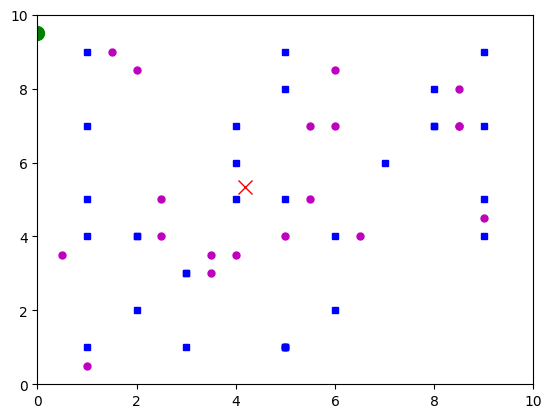

Agent's Current Position [0.  9.5]
Goal Position : [4.18 5.33]
Action Taken : 7 - Left-Down
Agent's New Position [0.  8.5]
Steps taken : 616
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 

Distance to the Goal : 5.246074723066761
Del_Distance : -0.6582711340117342
Reward from Del_Dist : 2.633084536046937
******************************
Obstacle #0 Distance : 7.905694150420948
******************************
Obstacle #1 Distance : 9.656603957913983
******************************
Obstacle #2 Distance : 6.5
******************************
Obstacle #3 Distance : 8.74642784226795
******************************
Obstacle #4 Distance : 2.0
Penalty Obtained : 5.0
******************************
Obstacle #5 Distance : 6.020797289396148
******************************
Obstacle #6 Distance : 2.0615528128088303
Penalty Obtained : 4.85071250072666
******************************
Obstacle #7 Distance : 7.106335201775948
******************************
Obstacle #8 Distance : 8.13941029

In [12]:
model.learn(total_timesteps=1000000, callback=render_callback)